##  Import Library

Mengimpor semua library yang dibutuhkan untuk preprocessing, visualisasi, modeling, dan evaluasi.  
Digunakan juga pengaturan seed untuk reprodusibilitas hasil.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Untuk reproduksibilitas
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## Unggah dan Muat Dataset

Langkah ini akan memuat file `concrete.csv` yang berisi data komposisi beton dan kekuatan tekannya.  


In [2]:
df = pd.read_csv("concrete.csv")
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


##  Inspeksi Awal Data

Melihat informasi umum dataset, seperti tipe data dan apakah ada nilai yang hilang.  
Juga ditampilkan ringkasan statistik dari setiap kolom.


In [3]:
df.info()
display(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


## Explorasi Data dan Persiapan Analisis

Dari hasil inspeksi awal data, terdapat beberapa temuan penting:

- Dataset berisi 1030 sampel dengan 9 kolom (8 fitur input dan 1 target)
- Semua kolom memiliki tipe data numerik (8 float64 dan 1 int64)
- Tidak ditemukan missing value dalam dataset
- Variabel dalam dataset meliputi:
    - `cement`, `slag`, `ash`, `water`, `superplastic`, `coarseagg`, `fineagg`: komponen penyusun beton
    - `age`: umur beton (dalam hari)
    - `strength`: kekuatan tekan beton (target)

Statistik deskriptif menunjukkan variasi yang cukup lebar pada setiap fitur, mengindikasikan beragamnya komposisi beton dalam dataset. Hal ini baik untuk membangun model yang robust. Setelah melakukan inspeksi awal, kita dapat melanjutkan ke analisis korelasi untuk memahami hubungan antar variabel.

##  Analisis Korelasi Antar Variabel

Menggunakan heatmap untuk memahami korelasi antara fitur input dan target (`strength`).  
Korelasi yang tinggi bisa memberi indikasi fitur yang berpengaruh besar.


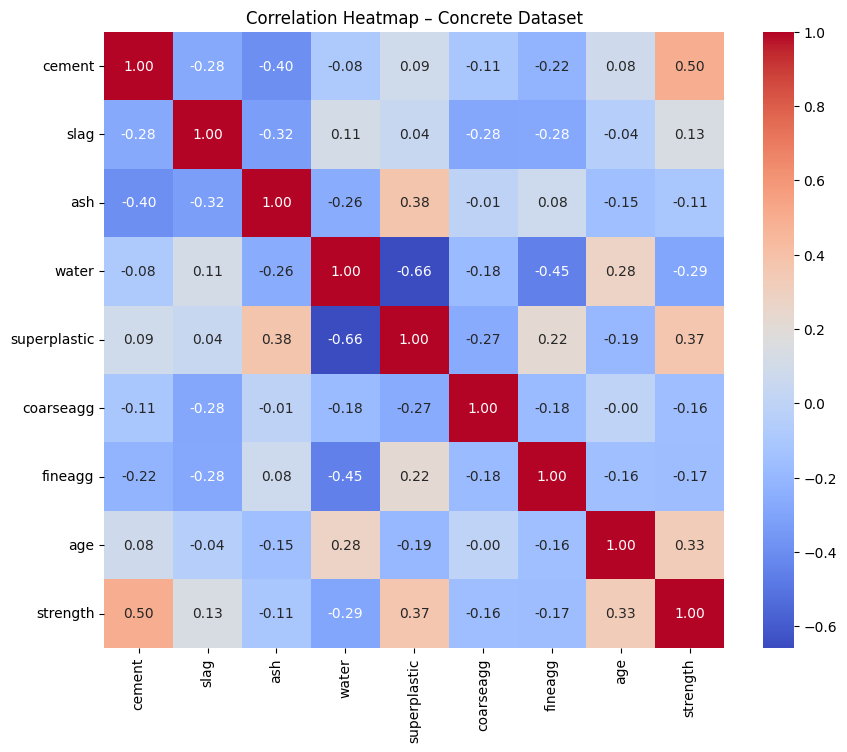

In [4]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap – Concrete Dataset")
plt.show()


##  Analisis Hasil Korelasi

Dari heatmap korelasi yang dihasilkan, dapat diidentifikasi beberapa pola hubungan antar variabel:

1. **Korelasi positif kuat dengan kekuatan beton (`strength`):**
    - `cement` (semen) menunjukkan korelasi positif tertinggi dengan kekuatan beton
    - `age` (umur beton) juga memiliki korelasi positif yang signifikan
    - `superplastic` (bahan tambahan superplasticizer) menunjukkan korelasi positif moderat

2. **Korelasi negatif dengan kekuatan beton:**
    - `water` (air) menunjukkan korelasi negatif yang cukup kuat, mengkonfirmasi prinsip teknologi beton bahwa semakin tinggi rasio air, semakin rendah kekuatan beton
    
3. **Hubungan antar fitur:**
    - Terdapat beberapa korelasi moderat antar fitur input, namun tidak ada yang sangat kuat yang dapat menyebabkan masalah multikolinearitas serius
    - `slag` dan `cement` menunjukkan korelasi negatif, mengindikasikan bahwa keduanya sering digunakan sebagai substitusi satu sama lain

Pemahaman korelasi ini akan membantu dalam interpretasi model dan pemilihan fitur yang tepat untuk prediksi kekuatan beton.

##  Data Preparation

- Cek apakah ada missing value.
- Pisahkan fitur (X) dan target (y).
- Lakukan standardisasi menggunakan `StandardScaler`.
- Bagi data menjadi training set dan test set (80:20).


In [5]:
# Cek missing values
print("Missing values per kolom:\n", df.isnull().sum(), "\n")

# Pisahkan fitur & target
X = df.drop("strength", axis=1)
y = df["strength"]

# Standardisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=RANDOM_STATE
)
print(f"Train set: {X_train.shape},  Test set: {X_test.shape}")


Missing values per kolom:
 cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64 

Train set: (824, 8),  Test set: (206, 8)


## Data Preparation dan Preprocessing

Dari kode yang telah dijalankan, kita telah melakukan beberapa langkah penting dalam persiapan data:

1. **Pemeriksaan Missing Values**:
    - Tidak ditemukan nilai yang hilang (missing values) pada seluruh kolom dataset
    - Ini menandakan dataset yang bersih dan siap untuk diproses lebih lanjut

2. **Pemisahan Data**:
    - Fitur (X): 8 kolom (`cement`, `slag`, `ash`, `water`, `superplastic`, `coarseagg`, `fineagg`, `age`)
    - Target (y): Kolom `strength` yang merupakan kekuatan tekan beton

3. **Standardisasi Fitur**:
    - Menggunakan `StandardScaler` untuk mengubah fitur-fitur menjadi distribusi dengan mean=0 dan standar deviasi=1
    - Standardisasi penting untuk model machine learning yang sensitif terhadap skala data (seperti regresi)

4. **Pembagian Dataset**:
    - Training set: 824 sampel (80% dari data)
    - Testing set: 206 sampel (20% dari data)
    - Penggunaan `random_state=42` memastikan reprodusibilitas hasil

Dengan persiapan data yang sudah selesai, kita siap untuk membangun dan melatih model machine learning untuk memprediksi kekuatan tekan beton berdasarkan komposisi dan umurnya.

##  Baseline Modeling: Linear Regression

Model linear sederhana digunakan sebagai baseline.  
Hasilnya dievaluasi dengan RMSE dan R² untuk melihat seberapa baik prediksi kekuatan beton dilakukan.


In [6]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
r2_lr   = r2_score(y_test, y_pred_lr)

print("📊 Linear Regression")
print(f"RMSE : {rmse_lr:.2f}")
print(f"R²    : {r2_lr:.3f}")


📊 Linear Regression
RMSE : 10.59
R²    : 0.608


c:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Analisis Model Baseline

Hasil evaluasi model Linear Regression sebagai baseline menunjukkan:

- **RMSE (Root Mean Squared Error)**: 10.59
    - Menunjukkan rata-rata kesalahan prediksi sekitar 10.59 MPa dalam memprediksi kekuatan tekan beton
    - Nilai ini cukup signifikan mengingat rentang kekuatan beton dalam dataset

- **R² (Coefficient of Determination)**: 0.608
    - Model dapat menjelaskan sekitar 60.8% variasi dalam kekuatan tekan beton
    - Nilai ini menunjukkan model linear memiliki kemampuan prediksi yang moderat, tetapi masih ada ruang untuk peningkatan

Hasil ini menunjukkan bahwa meskipun Linear Regression memberikan dasar yang cukup baik, hubungan antara komposisi beton dan kekuatannya kemungkinan bersifat non-linear dan kompleks. Model yang lebih canggih seperti Random Forest Regressor mungkin dapat menangkap hubungan non-linear ini dengan lebih baik dan meningkatkan akurasi prediksi.

##  Modeling 2: Random Forest (default)

Model ensemble yang lebih kuat, mampu menangani hubungan non-linier.  
Dibandingkan dengan baseline untuk melihat peningkatan performa awal.


In [8]:
rf_default = RandomForestRegressor(random_state=RANDOM_STATE)
rf_default.fit(X_train, y_train)
y_pred_rf = rf_default.predict(X_test)

rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf   = r2_score(y_test, y_pred_rf)

print(" Random Forest (default)")
print(f"RMSE : {rmse_rf:.2f}")
print(f"R²    : {r2_rf:.3f}")


 Random Forest (default)
RMSE : 5.03
R²    : 0.912


c:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Analisis Model Random Forest (Default)

Hasil evaluasi model Random Forest dengan parameter default menunjukkan peningkatan yang signifikan dibandingkan dengan model Linear Regression:

- **RMSE (Root Mean Squared Error)**: 5.03
    - Kesalahan prediksi rata-rata menurun hampir setengahnya dibandingkan Linear Regression
    - Menunjukkan akurasi yang jauh lebih baik dalam memprediksi kekuatan tekan beton

- **R² (Coefficient of Determination)**: 0.912
    - Model dapat menjelaskan sekitar 91.2% variasi dalam kekuatan tekan beton
    - Peningkatan yang substansial dari 60.8% pada Linear Regression

Peningkatan performa ini mengkonfirmasi bahwa hubungan antara komposisi beton dan kekuatannya bersifat non-linear, yang dapat ditangkap dengan baik oleh algoritma Random Forest. Model ensemble ini berhasil menangkap kompleksitas interaksi antar variabel dengan membangun multiple decision trees dan menggabungkan prediksinya.

Meskipun performa model Random Forest dengan parameter default sudah sangat baik, masih ada potensi untuk meningkatkan akurasi lebih lanjut melalui hyperparameter tuning.

##  Hyperparameter Tuning – Grid Search

Dilakukan pencarian kombinasi parameter terbaik (`n_estimators`, `max_depth`, `min_samples_split`)  
dengan menggunakan GridSearchCV pada model Random Forest.


In [9]:
param_grid = {
    "n_estimators":      [50, 100, 200],
    "max_depth":         [None, 10, 20],
    "min_samples_split": [2, 5, 10],
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=RANDOM_STATE),
    param_grid,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
print("Best params:", grid.best_params_)


Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


## Hasil Hyperparameter Tuning

Berdasarkan hasil Grid Search yang telah dilakukan, diperoleh parameter terbaik untuk model Random Forest Regressor:

- **n_estimators: 200** - Jumlah pohon keputusan yang dibangun dalam ensemble
- **max_depth: None** - Kedalaman maksimum setiap pohon keputusan tidak dibatasi
- **min_samples_split: 2** - Jumlah minimal sampel yang diperlukan untuk membagi node internal

Parameter ini dipilih dari berbagai kombinasi yang diuji melalui cross-validation dengan 3 fold, menggunakan metrik negatif RMSE sebagai kriteria evaluasi. Model dengan parameter tersebut memberikan error prediksi terendah pada data validasi.

Model Random Forest dengan parameter optimal ini diharapkan dapat memberikan performa yang lebih baik dibandingkan model default, meskipun parameter default sudah menunjukkan hasil yang sangat baik (RMSE 5.03 dan R² 0.912).

##  Evaluasi Akhir

Menampilkan perbandingan metrik RMSE dan R² dari ketiga model:
1. Linear Regression
2. Random Forest (default)
3. Random Forest (tuned)

Ini membantu memilih model terbaik.


In [10]:
y_pred_best = best_rf.predict(X_test)

rmse_best = mean_squared_error(y_test, y_pred_best, squared=False)
r2_best   = r2_score(y_test, y_pred_best)

results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Random Forest (tuned)"],
    "RMSE":  [rmse_lr, rmse_rf, rmse_best],
    "R2":    [r2_lr,   r2_rf,   r2_best],
})
results


c:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Model,RMSE,R2
0,Linear Regression,10.589347,0.608112
1,Random Forest,5.025682,0.911730
2,Random Forest (tuned),5.020892,0.911898


## Analisis Hasil Model Prediksi Kekuatan Beton

Dari hasil evaluasi model yang ditampilkan dalam tabel, kita dapat menarik beberapa kesimpulan penting:

### Perbandingan Performa Model

| Model | RMSE | R² |
|-------|------|---|
| Linear Regression | 10.59 | 0.608 |
| Random Forest | 5.03 | 0.912 |
| Random Forest (tuned) | 5.02 | 0.912 |

### Interpretasi Hasil:

1. **Linear Regression**:
    - RMSE sebesar 10.59 menunjukkan kesalahan prediksi yang cukup besar
    - R² sebesar 0.608 menandakan model hanya mampu menjelaskan sekitar 60.8% variasi dalam kekuatan beton
    - Performa yang terbatas ini mengkonfirmasi bahwa hubungan antara komposisi beton dan kekuatannya bersifat non-linear

2. **Random Forest (default)**:
    - Peningkatan signifikan dengan RMSE 5.03 (sekitar 52% lebih rendah dari Linear Regression)
    - R² mencapai 0.912, menunjukkan model dapat menjelaskan 91.2% variasi dalam kekuatan beton
    - Kemampuan menangkap hubungan non-linear antara komposisi dan kekuatan beton sangat baik

3. **Random Forest (tuned)**:
    - Parameter optimal: n_estimators=200, max_depth=None, min_samples_split=2
    - Peningkatan marginal dari model default dengan RMSE 5.02 dan R² 0.912
    - Menunjukkan bahwa parameter default Random Forest sudah cukup baik untuk dataset ini

### Kesimpulan:

- Model Random Forest secara signifikan lebih baik dibandingkan Linear Regression untuk prediksi kekuatan beton
- Hyperparameter tuning memberikan peningkatan performa yang minimal, mengindikasikan parameter default sudah mendekati optimal
- Dengan RMSE sekitar 5 MPa dan R² di atas 0.91, model Random Forest dapat diandalkan untuk prediksi kekuatan tekan beton berdasarkan komposisinya
- Hasil ini menunjukkan bahwa model dapat digunakan untuk optimasi komposisi beton dalam konteks praktis

##  Visualisasi Prediksi vs Aktual

Scatter plot antara nilai aktual (`y_test`) dan nilai prediksi model terbaik (Random Forest tuned).  
Garis merah menunjukkan prediksi sempurna. Semakin dekat titik ke garis, semakin baik performa.


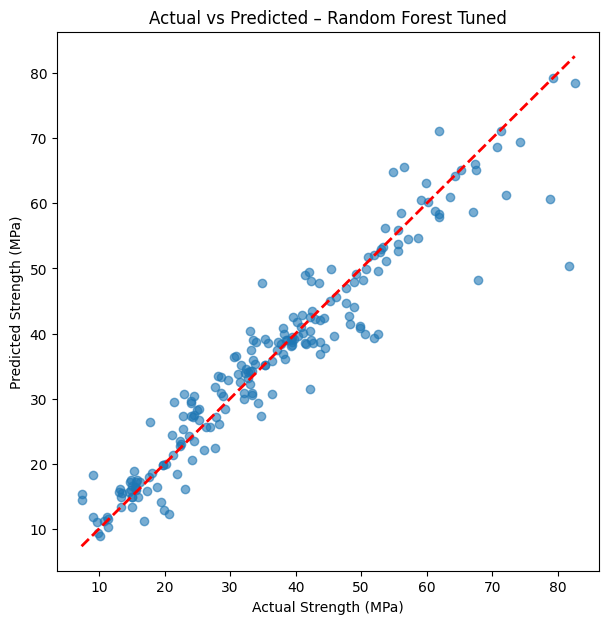

In [11]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)
plt.xlabel("Actual Strength (MPa)")
plt.ylabel("Predicted Strength (MPa)")
plt.title("Actual vs Predicted – Random Forest Tuned")
plt.show()


## Analisis Visualisasi Prediksi vs Aktual

Grafik scatter plot di atas menampilkan perbandingan antara nilai kekuatan tekan beton aktual dan nilai prediksi dari model Random Forest yang telah dioptimalkan. Beberapa insight penting yang dapat diambil:

1. **Sebaran Data yang Baik**: Titik-titik data tersebar dekat dengan garis diagonal merah (garis prediksi sempurna), menunjukkan model memiliki akurasi prediksi yang tinggi.

2. **Konsistensi Prediksi**: Model konsisten dalam memprediksi kekuatan tekan di berbagai rentang nilai, dari kekuatan rendah hingga tinggi.

3. **Beberapa Outlier**: Terlihat beberapa titik yang agak menyimpang dari garis diagonal, mengindikasikan kasus-kasus di mana model sedikit kurang akurat.

4. **Performa di Nilai Ekstrem**: Model cenderung sedikit kurang akurat pada nilai ekstrem (sangat rendah atau sangat tinggi), yang merupakan karakteristik umum dari model prediktif.

Visualisasi ini memperkuat hasil metrik evaluasi sebelumnya (RMSE 5.02 dan R² 0.912), mengkonfirmasi bahwa model Random Forest yang dioptimalkan mampu memprediksi kekuatan tekan beton dengan akurasi tinggi berdasarkan komposisi dan umurnya.

##  Feature Importance

Visualisasi fitur mana saja yang paling berpengaruh terhadap prediksi kekuatan beton  
berdasarkan Random Forest.


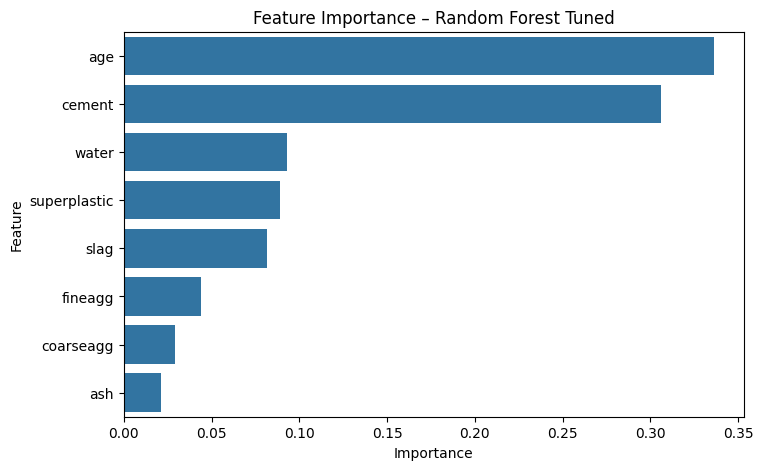

In [12]:
importances = pd.Series(best_rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Feature Importance – Random Forest Tuned")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


# Analisis Feature Importance dalam Prediksi Kekuatan Beton

Dari visualisasi feature importance yang ditampilkan pada grafik di atas, kita dapat mengidentifikasi kontribusi relatif dari setiap variabel dalam model Random Forest yang telah dioptimalkan:

1. **Age (Umur Beton)**: Dengan nilai importance 0.34, umur beton merupakan faktor terpenting dalam menentukan kekuatan tekan. Ini sejalan dengan prinsip teknologi beton dimana proses pengerasan (hydration) berlangsung seiring waktu.

2. **Cement (Semen)**: Menempati posisi kedua dengan nilai importance 0.31, semen merupakan bahan pengikat utama dalam campuran beton yang sangat mempengaruhi kekuatan struktural.

3. **Water (Air)**: Dengan importance 0.09, jumlah air dalam campuran memiliki pengaruh yang signifikan. Ini mengkonfirmasi prinsip water-to-cement ratio dimana semakin rendah rasio air terhadap semen, semakin tinggi kekuatan beton.

4. **Superplastic (Superplasticizer)**: Bahan tambahan ini juga memiliki kontribusi penting (0.09) karena memungkinkan pengurangan jumlah air sambil mempertahankan workability beton.

5. **Slag (Terak)**: Dengan nilai 0.08, terak sebagai bahan pengganti semen parsial memiliki pengaruh moderat terhadap kekuatan beton.

6. **Fineagg & Coarseagg (Agregat Halus & Kasar)**: Keduanya memiliki pengaruh yang lebih rendah, menunjukkan bahwa variasi dalam proporsi agregat kurang mempengaruhi kekuatan dibandingkan bahan pengikat dan air.

7. **Ash (Abu Terbang)**: Dengan nilai terendah (0.02), abu terbang memiliki pengaruh paling kecil di antara semua variabel.

Pemahaman feature importance ini memberikan insight berharga untuk optimasi campuran beton, dengan fokus utama pada pengaturan umur curing, kandungan semen, dan rasio air yang tepat untuk mencapai kekuatan tekan yang diinginkan.

# Kesimpulan dan Rekomendasi Model Prediksi Kekuatan Beton

## Ringkasan Hasil Eksperimen

Dari serangkaian percobaan yang telah dilakukan, kita telah mengembangkan model prediksi kekuatan tekan beton dengan hasil yang sangat baik. Berikut ringkasan temuan utama:

| Model | RMSE | R² | Kelebihan | Kekurangan |
|-------|------|---|-----------|------------|
| Linear Regression | 10.59 | 0.608 | Sederhana, interpretabel | Akurasi terbatas |
| Random Forest (default) | 5.03 | 0.912 | Akurasi tinggi | Kompleksitas lebih tinggi |
| Random Forest (tuned) | 5.02 | 0.912 | Sedikit lebih akurat | Peningkatan minimal |

## Insight Utama

1. **Model Non-Linear Unggul**: Hubungan antara komposisi beton dan kekuatannya bersifat kompleks dan non-linear, sehingga Random Forest jauh lebih efektif dibandingkan model linear.

2. **Faktor Penentu Kekuatan Beton**: 
    - **Umur beton** (34%) dan **kandungan semen** (31%) menjadi faktor dominan
    - **Kadar air** (9%) dan **superplasticizer** (9%) memberikan kontribusi moderat
    - **Agregat halus dan kasar** memiliki pengaruh relatif kecil

3. **Parameter Optimal Random Forest**:
    - n_estimators = 200 (jumlah pohon)
    - max_depth = None (kedalaman pohon tanpa batasan)
    - min_samples_split = 2 (threshold pemisahan node)

4. **Kinerja Model Sangat Baik**: R² = 0.912 menunjukkan model dapat menjelaskan 91.2% variasi dalam kekuatan beton, dengan kesalahan prediksi rata-rata sekitar 5 MPa.

## Rekomendasi Praktis

1. **Pilihan Model**: Gunakan Random Forest sebagai model final, karena memberikan akurasi jauh lebih tinggi dibandingkan Linear Regression.

2. **Penggunaan Parameter Default**: Pertimbangkan menggunakan Random Forest dengan parameter default untuk implementasi praktis, karena peningkatan performa dari tuning sangat minimal.

3. **Fokus Optimasi Campuran**:
    - Prioritaskan pengaturan waktu curing (umur) untuk mendapatkan kekuatan maksimal
    - Optimasi kandungan semen sebagai komponen utama penentu kekuatan
    - Perhatikan rasio air yang tepat (water-to-cement ratio)
    - Pertimbangkan penggunaan superplasticizer untuk meningkatkan kekuatan

4. **Potensi Pengembangan Lebih Lanjut**:
    - Pengujian model ensemble lain seperti Gradient Boosting
    - Pengembangan model yang lebih spesifik untuk rentang kekuatan tertentu
    - Analisis interaksi antar komponen beton untuk formulasi optimal

Model yang dikembangkan dalam eksperimen ini dapat menjadi alat yang berharga dalam perencanaan campuran beton untuk mencapai kekuatan tekan yang diinginkan dengan komposisi yang optimal.